- このベースラインは運営側のチュートリアル的な立ち位置です。
- コンペ後すぐではなく、開始後3時間を目処に公開予定です。

In [0]:
pwd

'/content'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import pickle
import pandas_profiling

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline


DIR = 'drive/My Drive/rakus_cup/data'
train = pd.read_csv(os.path.join(DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DIR, 'test.csv'))
sub = pd.read_csv(os.path.join(DIR, 'sample_submission.csv'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
print('train shape: ', train.shape)
train.head(2)

train shape:  (17819, 10)


,AnimalID,Name,DateTime,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeType
0,0,Smokeybear,2015-10-13 14:17:00,Partner,Dog,Neutered Male,10 years,Chow Chow Mix,Black,Transfer
1,1,Grandy,2014-02-22 14:54:00,NaN,Dog,Neutered Male,10 years,German Shepherd/Siberian Husky,Tricolor,Adoption


In [0]:
# trainに存在するOutcomeTypeが存在しない（=今回の目的変数）
print('test shape: ', test.shape)
test.head(2)

test shape:  (8910, 8)


,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,17819,Grizzly,2015-12-29 13:55:00,Dog,Spayed Female,3 years,Great Pyrenees Mix,White
1,17820,Lucky,2013-12-28 15:26:00,Dog,Neutered Male,2 years,Labrador Retriever Mix,Black/White


In [0]:
# 5つのクラスの確率を出力する
print('sub shape: ', sub.shape)
sub.head(2)

sub shape:  (8910, 6)


,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,17819,1,0,0,0,0
1,17820,1,0,0,0,0


## データの外観
### targetの分布

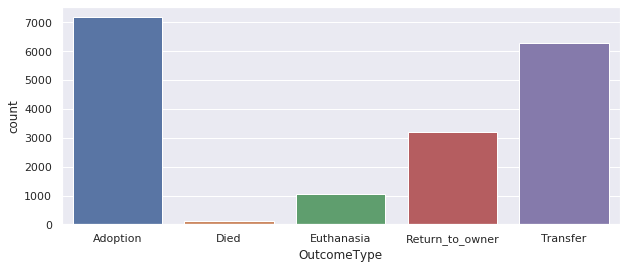

In [0]:
plt.figure(figsize=(10, 4))
sns.countplot(x='OutcomeType', data=train, order=['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']);

### OutcoemSubtypeの分布

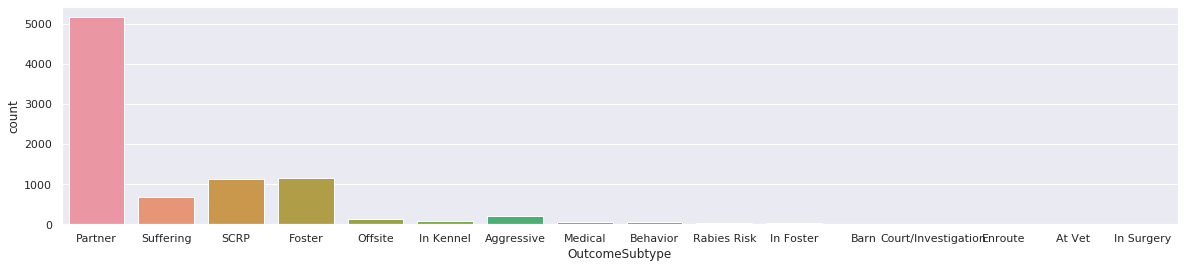

In [0]:
plt.figure(figsize=(20, 4))
sns.countplot(x='OutcomeSubtype', data=train);

### データ型と欠損割合、およびユニーク数の確認

In [0]:
train.dtypes

AnimalID           int64
Name              object
DateTime          object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
OutcomeType       object
dtype: object

In [0]:
train.isnull().sum() / train.shape[0]

AnimalID          0.000000
Name              0.290869
DateTime          0.000000
OutcomeSubtype    0.510017
AnimalType        0.000000
SexuponOutcome    0.000056
AgeuponOutcome    0.000842
Breed             0.000000
Color             0.000000
OutcomeType       0.000000
dtype: float64

In [0]:
test.isnull().sum() / test.shape[0]

AnimalID          0.000000
Name              0.281481
DateTime          0.000000
AnimalType        0.000000
SexuponOutcome    0.000000
AgeuponOutcome    0.000337
Breed             0.000000
Color             0.000000
dtype: float64

In [0]:
train.nunique()

AnimalID          17819
Name               4896
DateTime          15863
OutcomeSubtype       16
AnimalType            2
SexuponOutcome        5
AgeuponOutcome       44
Breed              1128
Color               317
OutcomeType           5
dtype: int64

In [0]:
test.nunique()

AnimalID          8910
Name              3151
DateTime          8351
AnimalType           2
SexuponOutcome       5
AgeuponOutcome      44
Breed              766
Color              257
dtype: int64

### pandas-profiling

In [0]:
pandas_profiling.ProfileReport(train)

Number of variables,10
Number of observations,17819
Total Missing (%),8.0%
Total size in memory,1.4 MiB
Average record size in memory,80.0 B
Numeric,1
Categorical,9
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [0]:
  pandas_profiling.ProfileReport(test)

Number of variables,8
Number of observations,8910
Total Missing (%),3.5%
Total size in memory,557.0 KiB
Average record size in memory,64.0 B
Numeric,1
Categorical,7
Boolean,0
Date,0
Text (Unique),0
Rejected,0


## 前処理
- ベースラインということで前処理は敢えて、必要最低限しかやりません。
- カテゴリ変数のエンコーディングは単純にラベルエンコーディングをしただけです。
- target encodingをする際はリークに気を付けてみてください。
- trainにしか存在しないOutcomeSubtypeはもしかすると有用な特徴量かもしれませんが、このベースラインでは使用しません。
- testに存在しない特徴量の場合、それ自体を予測した上でtestに改めて追加した後に目的変数を予測するなどの手法も存在します。（stacking）

In [0]:
def path_conf(path):
    if os.path.exists(path)==False:
        os.mkdir(path)

        
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    
# targetのエンコーディング
def make_target(train):
    y_train = train['OutcomeType'].values
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    return y_train, le


# train, testを結合。まとめて特徴量エンジニアリング処理
def df_trian_test_concat(train, test):
    train = train.drop(['OutcomeType', 'OutcomeSubtype'], axis=1)
    df = pd.concat([train, test], sort=False).reset_index(drop=True)
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    use_col = [c for c in df.columns if c not in 'AnimalID']
    df = df[use_col]
    return df


# 特徴量エンジニアリング
def male_or_female(x):
    if x=='Neutered Male' or x=='Intact Male':
        return 'Male'
    elif x=='Spayed Female' or x=='Intact Female':
        return 'Female'
    else:
        return 'Unknown'
    

def change_age(x):
    try:
        num, date = x.split()
    except:
        return -999
    else:
        num = int(num)
        if date=='year' or date=='years':
            return num
        elif date=='month' or date=='months':
            return num/12
        elif date=='week' or date=='weeks':
            return num/52
        else:
            return num/365

    
def make_feature(df):
    """
    もちろん下記の特徴量以外にも何かしらの処理をした方が良いと思いますが、ベースラインではそのままいきます。
    """
    df['Name'] = df['Name'].fillna('missing').apply(lambda x: 1 if x=='missing' else 0)
    df['Year'] = df['DateTime'].dt.year
    df['Month'] = df['DateTime'].dt.month
    df['Day'] = df['DateTime'].dt.day
    df['Dayofweek'] = df['DateTime'].dt.dayofweek
    df['hour'] = df['DateTime'].dt.hour
    df['Sex'] = df['SexuponOutcome'].fillna('missing').apply(male_or_female)
    df['AgeuponOutcome'] = df['AgeuponOutcome'].apply(change_age)
    df = df.drop('DateTime', axis=1)
    return df

In [0]:
df = df_trian_test_concat(train, test)
df = make_feature(df)

cat_col = [c for c in df.columns if df[c].dtype==object]
df[cat_col] = df[cat_col].fillna('missing')
for c in cat_col:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c])

X_train, X_test = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop=True)
y_train, le_target = make_target(train)

In [0]:
X_train.head(2)

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Year,Month,Day,Dayofweek,hour,Sex
0,0,1,2,10.0,504,5,2015,10,13,1,14,1
1,0,1,2,10.0,727,307,2014,2,22,5,14,1


In [0]:
X_test.head(2)

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Year,Month,Day,Dayofweek,hour,Sex
0,0,1,3,3.0,764,318,2015,12,29,1,13,0
1,0,1,2,2.0,847,38,2013,12,28,5,15,1


In [0]:
y_train[:10]

array([4, 0, 0, 4, 2, 0, 0, 4, 0, 4])

In [0]:
cat_col

['AnimalType', 'SexuponOutcome', 'Breed', 'Color', 'Sex']

## model01 学習&推論
- fold数5 でOut-of-foldしていきます。
- クラスの分布が均衡になるようにStratifiedKFoldを使用します。
- 今回のデータセットでは時系列がシャッフルされたデータでモデリングを行います（Kaggle上でもそうでした。）
なので特に気にせずcvを切っていますが、時系列性を意識すべきデータセットでは注意が必要です。
- また、CVの切り方でリークが発生してしまうケースではGroupKFoldなども必要になってくる可能性があります。
- feature importanceをプロットしていますが、あくまでも学習データに対する寄与度です。
- validation dataに対する重要度をはかる指標として、permutation importanceなどもあります。
- 新しいversionのscikit-learnには標準搭載されているようですが、使う場合GBDTもscikit-learnのインターフェースで記述する必要があります。

In [0]:
TEST_CODE = False
SEED = 42
N_FOLDS = 5
N_CLASS = 5
MODEL_SAVE_DIR = 'drive/My Drive/rakus_cup/models'
CSV_SAVE_DIR = 'drive/My Drive/rakus_cup/pred_csv'
PREDICTION_NO = '01'
TEAM_NAME = 'rakuraku-seisan-tsukaizurai'
PARAM = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': N_CLASS,
    'seed': SEED,
    'num_leaves': 30,
    'learning_rate': 0.01,
}

if TEST_CODE:
    X_train, y_train = X_train.iloc[8000:10000, :], y_train[8000:10000]
    X_test = X_test[:1000]
    sub = sub[:1000]

In [0]:
def run1():
    seed_everything(SEED)
    path_conf(MODEL_SAVE_DIR)
    oof = np.zeros((X_train.shape[0], N_CLASS))
    pred = np.zeros((X_test.shape[0], N_CLASS))
    skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
    for i, (tr_ix, va_ix) in enumerate(skf.split(X_train, y_train)):
        print(f'===== Fold {i+1}/{N_FOLDS}    Start =====\n')
        start_time = time.time()
        X_tr, y_tr = X_train.iloc[tr_ix, :], y_train[tr_ix]
        X_va, y_va = X_train.iloc[va_ix, :], y_train[va_ix]

        tra_dataset = lgb.Dataset(X_tr, y_tr)
        val_dataset = lgb.Dataset(X_va, y_va)
        model = lgb.train(PARAM,
                         tra_dataset,
                         num_boost_round=10000,
                         valid_sets=val_dataset,
                         early_stopping_rounds=30,
                         verbose_eval=False,)
        oof[va_ix] = model.predict(X_va)
        pred += model.predict(X_test) / skf.n_splits

        val_score = log_loss(y_va, oof[va_ix])
        print(f'Validation Score: {val_score:.3f}\n')

        end_time = time.time()
        print(f'timer:  {(end_time - start_time):.3f} sec.\n')

        xgb.plot_importance(model, figsize=(6, 4), importance_type='gain')
        print()

        with open(os.path.join(MODEL_SAVE_DIR, f'model_{i+1}.pkl'), 'wb') as f:
            pickle.dump(model, f)
            
    val_score = log_loss(y_train, oof)
    print(f'\n\nTotal Validation Score: {val_score:.3f}\n')
            
    return oof, pred

===== Fold 1/5    Start =====

Validation Score: 0.755

timer:  13.382 sec.


===== Fold 2/5    Start =====

Validation Score: 0.744

timer:  15.433 sec.


===== Fold 3/5    Start =====

Validation Score: 0.763

timer:  14.839 sec.


===== Fold 4/5    Start =====

Validation Score: 0.770

timer:  14.756 sec.


===== Fold 5/5    Start =====

Validation Score: 0.794

timer:  14.033 sec.




Total Validation Score: 0.765



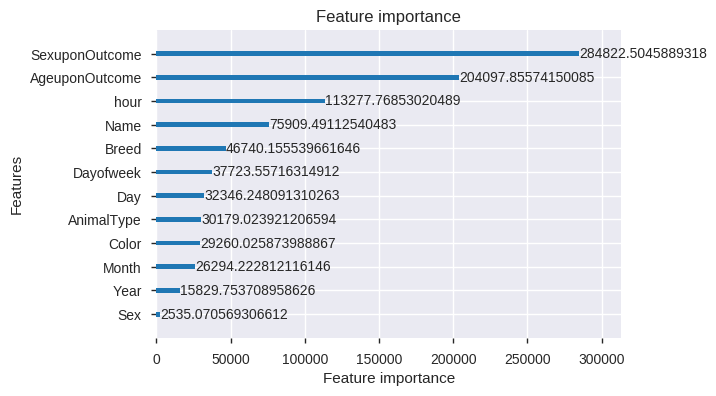

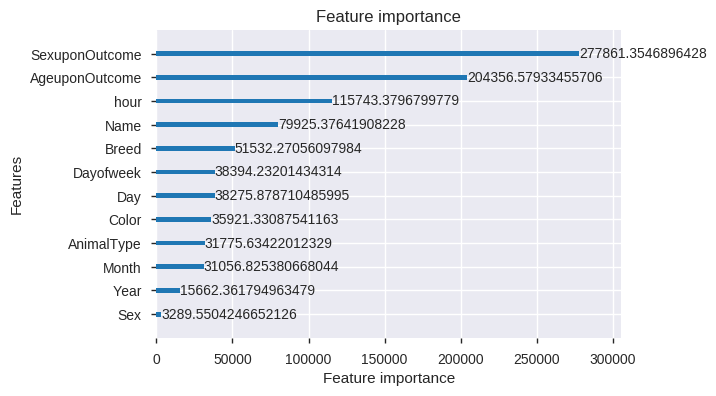

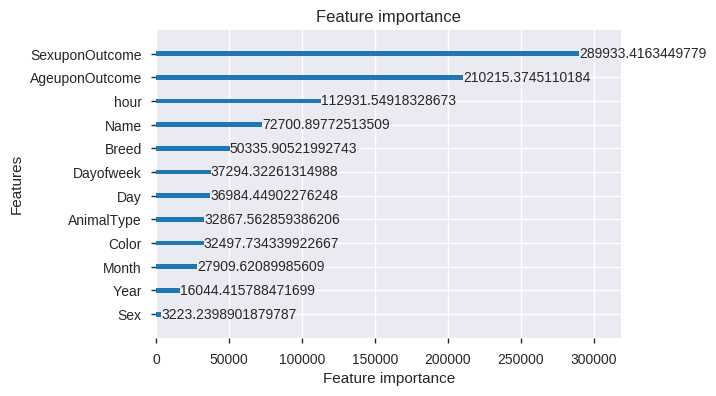

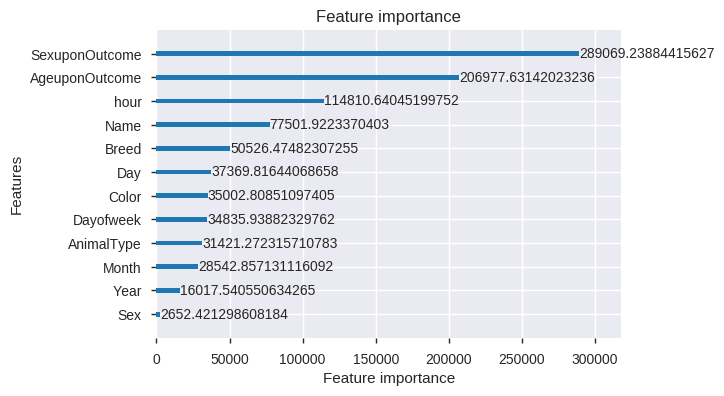

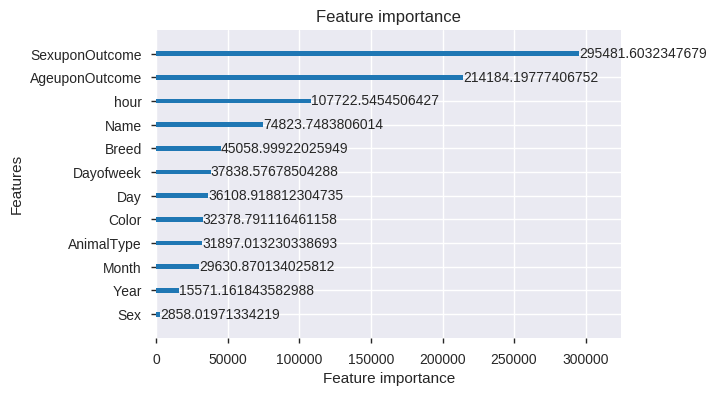

In [0]:
oof1, pred1 = run1()

## model2
- 犬と猫のデータを二分割し、別々に学習&推論させます
- Validation Scoreを見る限りどうやら、Dogの方がCatよりも精度が低いようです。
- また、両者のfeature importanceの傾向は若干異なるようです。
- 下記では、簡易的に犬猫とのみ同じ特徴量での学習ですが、別々のテーブルを作成しても面白いかもしれません。

In [0]:
def run2():
    seed_everything(SEED)
    path_conf(MODEL_SAVE_DIR)
    oof = np.zeros((X_train.shape[0], N_CLASS))
    pred = np.zeros((X_test.shape[0], N_CLASS))
    
    for animal in range(2):
        X_train_tmp = X_train[X_train['AnimalType']==animal]
        X_test_tmp = X_test[X_test['AnimalType']==animal]
        tr_idx_tmp, te_idx_tmp = X_train_tmp.index, X_test_tmp.index
        X_train_tmp = X_train_tmp.reset_index(drop=True)
        X_test_tmp = X_test_tmp.reset_index(drop=True)
        y_train_tmp = y_train[tr_idx_tmp]
        skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
        
        for i, (tr_ix, va_ix) in enumerate(skf.split(X_train_tmp, y_train_tmp)):
            print(f'===== Fold {i+1}/{N_FOLDS}    Start =====\n')
            start_time = time.time()
            X_tr, y_tr = X_train_tmp.iloc[tr_ix, :], y_train_tmp[tr_ix]
            X_va, y_va = X_train_tmp.iloc[va_ix, :], y_train_tmp[va_ix]

            tra_dataset = lgb.Dataset(X_tr, y_tr)
            val_dataset = lgb.Dataset(X_va, y_va)
            model = lgb.train(PARAM,
                             tra_dataset,
                             num_boost_round=10000,
                             valid_sets=val_dataset,
                             early_stopping_rounds=30,  
                             verbose_eval=False,)
            oof[tr_idx_tmp[va_ix]] = model.predict(X_va)
            pred[te_idx_tmp] += model.predict(X_test_tmp) / skf.n_splits

            val_score = log_loss(y_va, oof[tr_idx_tmp[va_ix]])
            if animal==0:
                print(f'Cat Validation Score: {val_score:.3f}\n')
            else:
                print(f'Dog Validation Score: {val_score:.3f}\n')

            end_time = time.time()
            print(f'timer:  {(end_time - start_time):.3f} sec.\n')
            
            if animal==0:
                lgb.plot_importance(model, figsize=(6, 4), importance_type='gain', title='Cat Feature importance')
            else:
                lgb.plot_importance(model, figsize=(6, 4), importance_type='gain', title='Dog Feature importance')
            print()

            with open(os.path.join(MODEL_SAVE_DIR, f'model_animal{animal}_valid{i+1}.pkl'), 'wb') as f:
                pickle.dump(model, f)
                
    val_score = log_loss(y_train, oof)
    print(f'\n\nTotal Validation Score: {val_score:.3f}\n')
            
    return oof, pred

===== Fold 1/5    Start =====

Cat Validation Score: 0.529

timer:  5.528 sec.


===== Fold 2/5    Start =====

Cat Validation Score: 0.547

timer:  4.682 sec.


===== Fold 3/5    Start =====

Cat Validation Score: 0.567

timer:  4.130 sec.


===== Fold 4/5    Start =====

Cat Validation Score: 0.544

timer:  5.240 sec.


===== Fold 5/5    Start =====

Cat Validation Score: 0.553

timer:  4.921 sec.


===== Fold 1/5    Start =====

Dog Validation Score: 0.926

timer:  7.660 sec.


===== Fold 2/5    Start =====

Dog Validation Score: 0.929

timer:  7.325 sec.


===== Fold 3/5    Start =====

Dog Validation Score: 0.924

timer:  7.437 sec.


===== Fold 4/5    Start =====

Dog Validation Score: 0.903

timer:  9.775 sec.


===== Fold 5/5    Start =====

Dog Validation Score: 0.906

timer:  7.679 sec.




Total Validation Score: 0.765



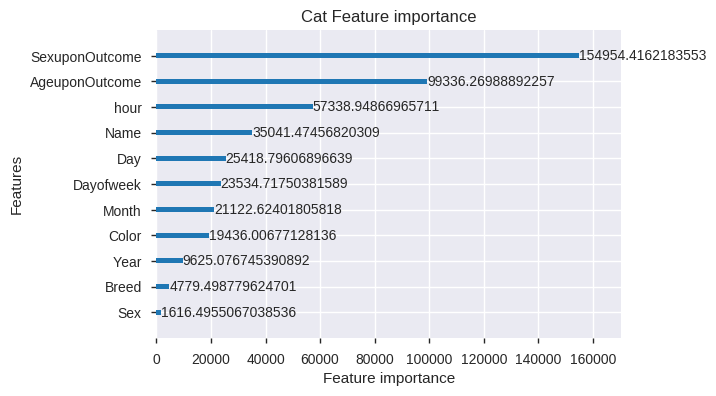

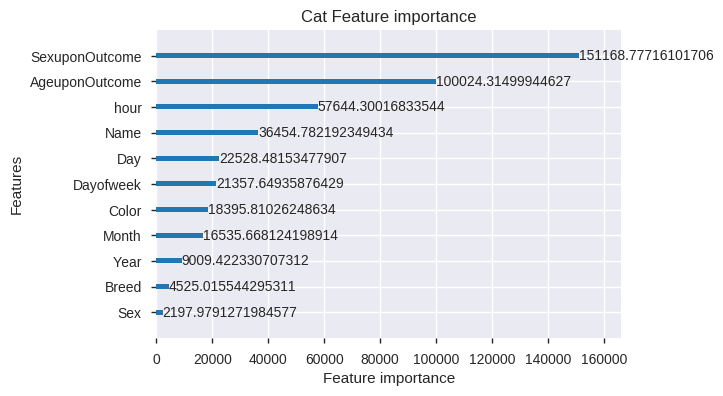

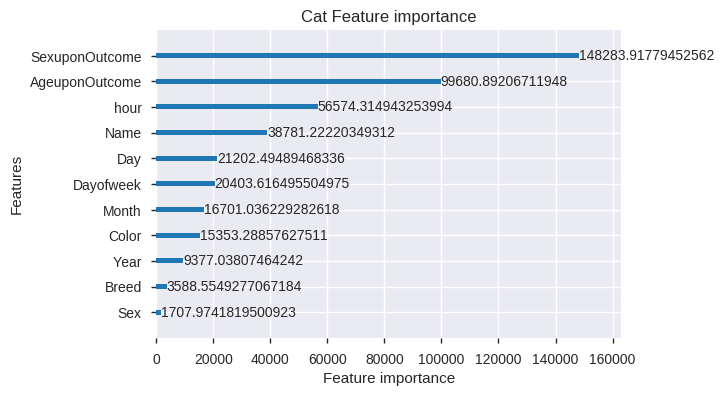

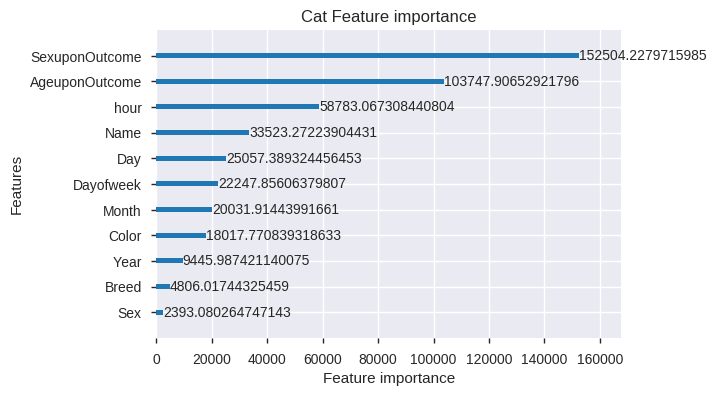

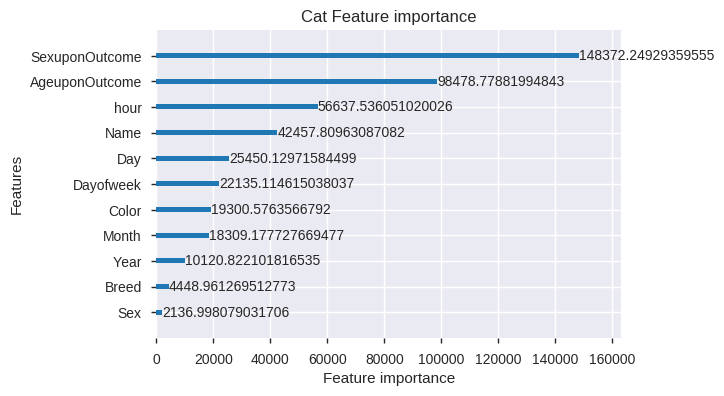

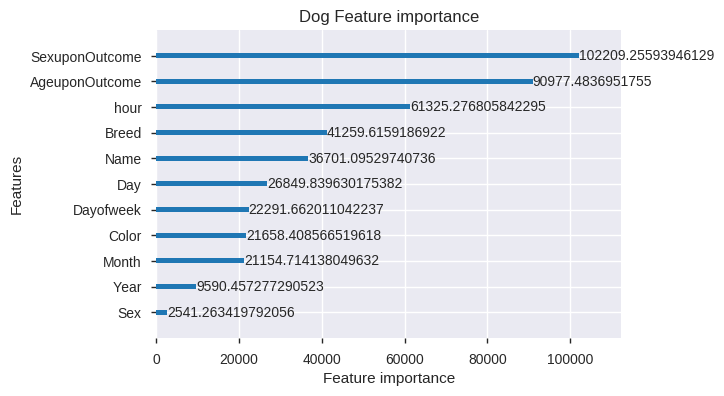

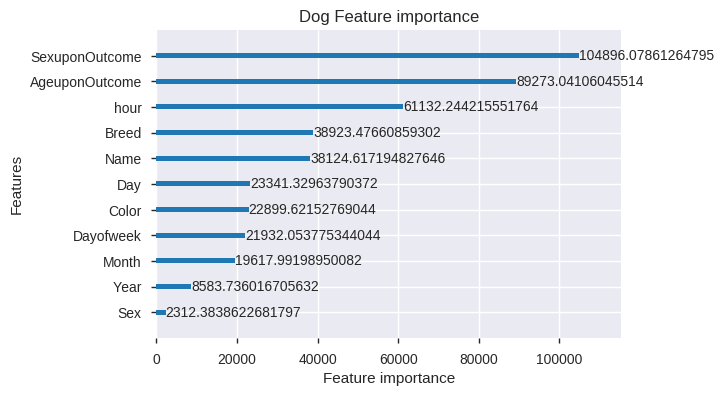

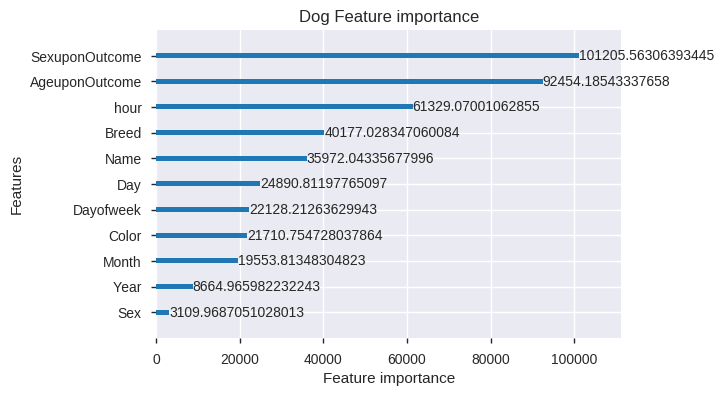

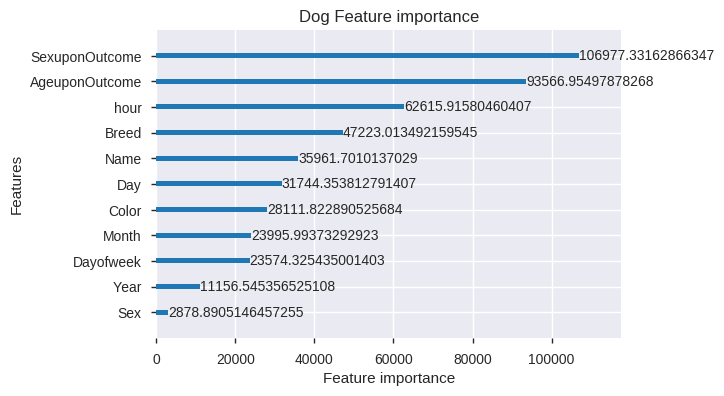

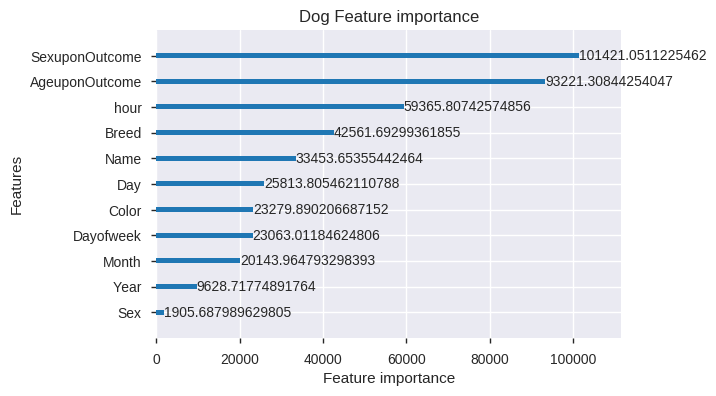

In [0]:
oof2, pred2 = run2()

## Ensemble - Blending¶
- 最終的にmodel1とmodel2の結果の平均を取ります。

In [0]:
oof = (oof1+oof2)/2
pred = (pred1+pred2)/2

val_score = log_loss(y_train, oof)
print(f'\n\nTotal Validation Score: {val_score:.3f}\n')
  
sub.iloc[:, 1:] = pred
sub.to_csv(f'{CSV_SAVE_DIR}/submission_{TEAM_NAME}_{PREDICTION_NO}.csv', index=False)



Total Validation Score: 0.757

